Import libs

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
import contextlib
import sys, os
import warnings
warnings.filterwarnings('ignore')


@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


Download data from yahoo finance

In [ ]:
# ==================== [1] DOWNLOAD DATA ====================
def download_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
    data['Date'] = data.index
    data = data.reset_index(drop=True)
    data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    data['Close'] = data['Adj Close']

    return data


In [ ]:
# ==================== [3] FRACTAL IDENTIFIER ====================
def is_fractal(data, i):
    """
    Detects bullish (1) or bearish (-1) fractals at a given index.
    """
    lows = data['Low'].values
    highs = data['High'].values

    if i < 2 or i > len(data) - 3:
        return 0  # Not enough candles around to form a fractal

    # Bullish fractal: center low is lowest among neighbors
    if (lows[i] < lows[i-1] and lows[i] < lows[i+1] and lows[i] < lows[i-2] and lows[i] < lows[i+2]):
        return 1

    # Bearish fractal: center high is highest among neighbors
    elif (highs[i] > highs[i-1] and highs[i] > highs[i+1] and highs[i] > highs[i-2] and highs[i] > highs[i+2]):
        return -1

    return 0

In [ ]:
# ==================== [4] ATR CALCULATOR ====================
def fill_atr(data, period=14):

    high = data['High']
    low = data['Low']
    close = data['Close']

    tr1 = high - low
    tr2 = (high - close.shift(1)).abs()
    tr3 = (low - close.shift(1)).abs()

    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()

    data['ATR'] = atr
    return data


CUSTOM INDICATOR
VTSI = EMA(t) - EMA(t-n) / ATR

In [ ]:
# ==================== [5] EMA & VTSI ====================

def vtsi(data, t, n):
    """
    Volume Trend Strength Indicator (VTSI)
    Formula: VTSI = (EMA(t) - EMA(t - n)) / ATR

    Assumes that 'ATR' column is already added by `fill_atr()`.
    """
    if 'ATR' not in data.columns:
        raise ValueError("ATR column missing. Please run `fill_atr(data)` first.")

    ema_t = data['Close'].squeeze().ewm(span=t, adjust=False).mean()
    ema_t_minus_n = data['Close'].squeeze().ewm(span=t-n, adjust=False).mean()

    atr_series = data['ATR'].squeeze()

    vtsi_series = (ema_t - ema_t_minus_n) / atr_series

    data['VTSI'] = vtsi_series

    return data

###Develop the Strategy
####Buy:
  When a bullish fractal is detected and vtsi > Threshold (high chance of  increase in stock).
####Sell:
  When a bearish fractal is detected and vtsi is < Threshold (high chance of price going down)

  threshold can be +/- 0.6  or  +/- 0.7

In [ ]:
# ==================== [6] STRATEGY RULE ====================
def strategy(data, threshold):
    data['Signal'] = 0  # Initialize with no signal

    for i in range(2, len(data) - 2):
        fractal = is_fractal(data, i) #u are calculating if a peak exists in t-2
        vtsi_val = data['VTSI'].iloc[i]
        atr = data['ATR'].iloc[i]
        close = data['Close'].iloc[i]

        # Skip bad values
        if pd.isna(vtsi_val) or isinstance(vtsi_val, pd.Series):
            continue

        # Logic for trades
        if fractal == 1 and vtsi_val >= threshold:
            data.at[data.index[i], 'Signal'] = 1
        elif fractal == -1 and vtsi_val <= -threshold:
            data.at[data.index[i], 'Signal'] = -1


In [ ]:
# ==================== [7] BACKTEST ====================
def backtest(data, initial_capital):
    """
    Backtests the strategy with fixed lot size = 100 shares
    """
    positions = pd.DataFrame(index=data.index)
    positions['Stock'] = 0.0

    portfolio = pd.DataFrame(index=data.index)
    portfolio['cash'] = 0.0
    portfolio['holdings'] = 0.0
    portfolio['total'] = 0.0
    portfolio['returns'] = 0.0

    # Initialize day 0
    portfolio.iloc[0, portfolio.columns.get_loc('cash')] = initial_capital
    portfolio.iloc[0, portfolio.columns.get_loc('total')] = initial_capital

    for i in range(1, len(data)):
        # Fetch Previous values
        cash = float(portfolio['cash'].iloc[i-1])
        stock = float(positions['Stock'].iloc[i-1])
        close = float(data['Close'].iloc[i])
        signal = float(data['Signal'].iloc[i])

        can_buy = cash >= (close * 100)
        can_sell = stock >= 100

        positions.iloc[i, positions.columns.get_loc('Stock')] = stock
        portfolio.iloc[i, portfolio.columns.get_loc('cash')] = cash

        # Generating the signal
        if signal == 1 and can_buy:
            stock += 100
            cash -= close * 100
        elif signal == -1 and can_sell:
            stock -= 100
            cash += close * 100

        # Update data after trade
        positions.iloc[i, positions.columns.get_loc('Stock')] = stock
        portfolio.iloc[i, portfolio.columns.get_loc('cash')] = cash

        holdings = stock * close
        total = holdings + cash

        portfolio.iloc[i, portfolio.columns.get_loc('holdings')] = holdings
        portfolio.iloc[i, portfolio.columns.get_loc('total')] = total

        if i > 1:
            previous_total = portfolio['total'].iloc[i - 1]
            portfolio.iloc[i, portfolio.columns.get_loc('returns')] = (total / previous_total) - 1

    return portfolio,positions




In [ ]:
# ==================== [8] GENERATE REPORT ====================
def generate_report(portfolio, initial_capital):
    """
    Generates performance metrics and equity curve.
    """
    total_return = portfolio['total'].iloc[-1] / initial_capital - 1
    annualized_return = (1 + total_return)**(252 / len(portfolio)) - 1
    annualized_volatility = portfolio['returns'].std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility

    print(f'Total Return: {total_return:.2%}')
    print(f'Annualized Return: {annualized_return:.2%}')
    print(f'Annualized Volatility: {annualized_volatility:.2%}')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')

    # Plot equity curve
    plt.figure(figsize=(12, 8))
    plt.plot(portfolio['total'],
             label='Total Portfolio Value',
             c = 'purple')
    plt.title('Equity Curve')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
def collect_metrics(portfolio, initial_capital):
    """
    Returns key performance metrics from the portfolio.
    """
    total_return = portfolio['total'].iloc[-1] / initial_capital - 1
    annualized_return = (1 + total_return)**(252 / len(portfolio)) - 1
    annualized_volatility = portfolio['returns'].std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility != 0 else 0

    return {
        'total_return_pct': float(round(total_return * 100, 2)),
        'cagr_pct': float(round(annualized_return * 100, 2)),
        'annual_volatility_pct': float(round(annualized_volatility * 100, 2)),
        'sharpe_ratio': float(round(sharpe_ratio, 2))
    }


[*********************100%***********************]  1 of 1 completed


Total Return: 264.49%
Annualized Return: 38.90%
Annualized Volatility: 19.04%
Sharpe Ratio: 2.04


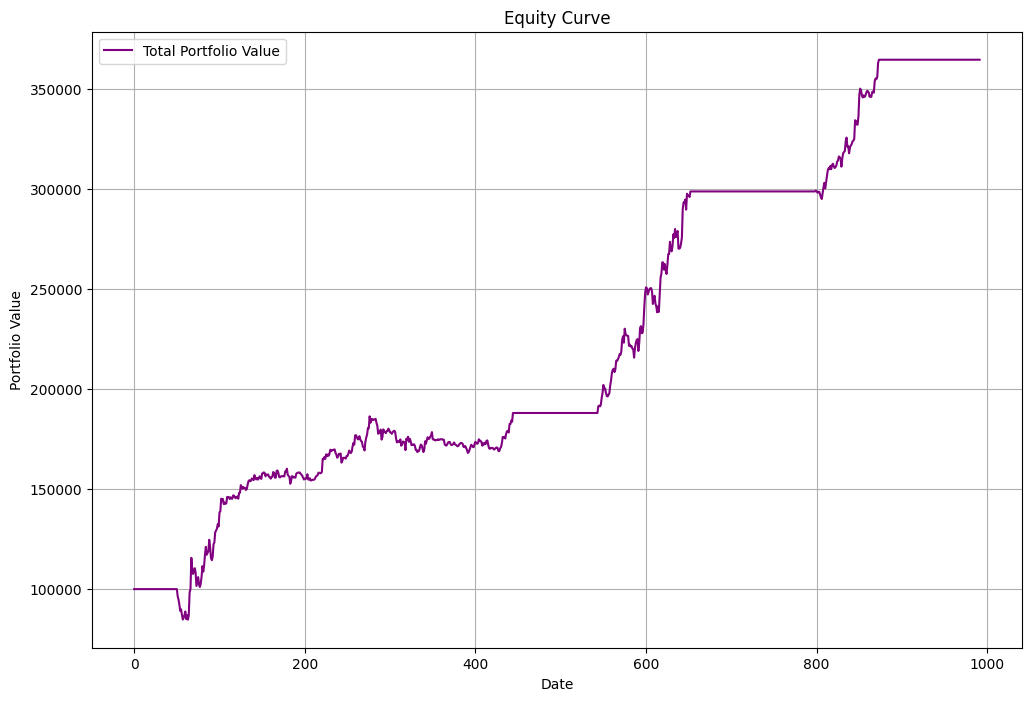

{'total_return_pct': 264.49, 'cagr_pct': 38.9, 'annual_volatility_pct': 19.04, 'sharpe_ratio': 2.04}


In [ ]:
# ======================== EXECUTE ================================
#This cell is to quick-backtest a single stock

data = download_data('M&M.NS', '2020-01-01', '2024-01-01')
with suppress_output():
    # Step 1: Calculate indicators and signals
    data = fill_atr(data, 14)
    vtsi(data, t=20, n=10)
    strategy(data, 0.6)

# Step 2: Backtest the strategy
initial_capital =100000
portfolio,positions = backtest(data, initial_capital)

# Step 3: Generate the performance report
generate_report(portfolio, initial_capital)
metrics = collect_metrics(portfolio, initial_capital)
print(metrics)

In [30]:
def extract_metrics(portfolio, initial_capital):

  total_return = portfolio['total'].iloc[-1] / initial_capital - 1
  annualized_return = (1 + total_return)**(252 / len(portfolio)) - 1
  annualized_volatility = portfolio['returns'].std() * np.sqrt(252)
  sharpe_ratio = annualized_return / annualized_volatility

  return{
      'Total Return': float(round(total_return * 100, 2)),
      'Annualized Return': float(round(annualized_return * 100, 2)),
      'Annualized Volatility': float(round(annualized_volatility * 100, 2)),
      'Sharpe Ratio': float(round(sharpe_ratio, 2))
  }

In [36]:
#=============== BACKTEST AND LOG ==================================
#Backtest and store stock-wise metrics
def backtest_and_log(stock_list, sheet, threshold, initial_capital):

  for stock in stock_list:
    data = download_data(stock, '2020-01-01', '2025-01-01')

    with suppress_output():
      data = fill_atr(data, 14)
      vtsi(data, t=20, n=10)
      strategy(data, threshold)

      portfolio, positions = backtest(data, initial_capital)

      metrics = extract_metrics(portfolio, initial_capital)

    row = [stock,
           metrics['Total Return'],
           metrics['Annualized Return'],
           metrics['Annualized Volatility'],
           metrics['Sharpe Ratio']]
    sheet.append_row(row)

  print("✅ All results logged to Google Sheet.")

In [33]:
#======================== SAVE DATA ===============================
import gspread
from oauth2client.service_account import ServiceAccountCredentials

#Define the scope
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

#Load credentials from json key
creds = ServiceAccountCredentials.from_json_keyfile_name('your_credentials.json', scope)
# Replace 'your_credentials.json' with your actual service account key file

#Authorize cliet
client = gspread.authorize(creds)

#Open your google sheets
spreadsheet = client.open_by_url("your_gsheet_link")
# Replace with your own G-Sheet URL (make sure shared with the service account)

sheet = spreadsheet.get_worksheet(0)

In [34]:
# For a Fresh Sheet
sheet.clear()
sheet.append_row(['Stock', 'Total Return', 'Annualized Return (%)', 'Annualized Volatility (%)', 'Sharpe Ratio'])


{'spreadsheetId': '17pbqg1DRwYGLI1Pz80DD6k1HifuvTS_FJq-tob3PlyM',
 'updates': {'spreadsheetId': '17pbqg1DRwYGLI1Pz80DD6k1HifuvTS_FJq-tob3PlyM',
  'updatedRange': 'Sheet1!A1:E1',
  'updatedRows': 1,
  'updatedColumns': 5,
  'updatedCells': 5}}

In [37]:
stock_list = ['ADANIENT.NS', 'M&M.NS', 'HINDALCO.NS', 'ADANIPOWER.NS']
backtest_and_log(stock_list,
                 sheet,
                 0.6,
                 100000)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ All results logged to Google Sheet.


In [38]:
# Export daily data to a csv file
def export_portfolio_view(data, portfolio, positions, output_name):

    result_df = pd.DataFrame()
    result_df['Date'] = data['Date']
    result_df['Close'] = data['Close']
    result_df['Signal'] = data['Signal'].astype(int)
    result_df['Portfolio Value'] = portfolio['total'].round(2)
    result_df['Rise/Fall'] = portfolio['total'].diff().fillna(0).round(2)
    result_df['Stocks Held'] = positions['Stock'].astype(int)
    result_df['Cash in Hand'] = portfolio['cash'].round(2)

    result_df.to_csv(output_name , index=False)
    print(f"Exported to {output_name}")

In [39]:
#=============== BACKTEST AND DOWNLOAD DAILY DATA ================
def backtest_and_download(stock_list, threshold, initial_capital):
    save_path = 'your_path' #replace with your pathname
    os.makedirs(save_path, exist_ok=True)

    for stock in stock_list:
        data = download_data(stock, '2020-01-01', '2024-01-01')

        with suppress_output():
            data = fill_atr(data, 14)
            vtsi(data, t=20, n=10)
            strategy(data, threshold)

            portfolio,positions = backtest(data, initial_capital)

            output_filename = f"{save_path}{stock}_portfolio.csv"
            export_portfolio_view(data, portfolio, positions, output_filename)
            print(f"✅ Saved: {stock}_portfolio.csv to daily_data")

    print("✅ All results downloaded as csv.")

In [40]:
# ============================ EXECUTE =================================
vtsi_07_stock = ['ADANIENT.NS', 'M&M.NS', 'HINDALCO.NS', 'ADANIPOWER.NS']
vtsi_06_stock = ['JSWSTEEL.NS', 'TATAMOTORS.NS', 'RELIANCE.NS']

initial_capital = 100000

# Run for 0.7 threshold stocks
backtest_and_download(vtsi_07_stock, threshold=0.7, initial_capital=initial_capital)

# Run for 0.6 threshold stocks
backtest_and_download(vtsi_06_stock, threshold=0.6, initial_capital=initial_capital)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ All results downloaded as csv.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ All results downloaded as csv.


ORGANIZING DATA

In [ ]:
#download data
from google.colab import drive
drive.mount('/Drive_path/')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Copy daily_data folder to drive
!cp -r daily_data/ "/Project_folder/"

In [ ]:
# Download the daily_data folder
!zip -r daily_data.zip daily_data
from google.colab import files
files.download('daily_data.zip')

  adding: daily_data/ (stored 0%)
  adding: daily_data/JSWSTEEL.NS_portfolio.csv (deflated 73%)
  adding: daily_data/TATAMOTORS.NS_portfolio.csv (deflated 74%)
  adding: daily_data/ADANIPOWER.NS_portfolio.csv (deflated 83%)
  adding: daily_data/M&M.NS_portfolio.csv (deflated 69%)
  adding: daily_data/RELIANCE.NS_portfolio.csv (deflated 76%)
  adding: daily_data/HINDALCO.NS_portfolio.csv (deflated 72%)
  adding: daily_data/ADANIENT.NS_portfolio.csv (deflated 78%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Combine Daily datas to single csv - Used for Analysis
import pandas as pd
import os

folder_path = 'folder_path'
combined_df = pd.DataFrame()

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        stock_name = filename.replace('.csv', '')
        df = pd.read_csv(os.path.join(folder_path, filename))
        df['Stock'] = stock_name  # Add a stock column
        combined_df = pd.concat([combined_df, df])

combined_df.to_csv('All_Daily_Stocks.csv', index=False)

In [ ]:
!cp All_Daily_Stocks.csv "/Project_folder/"